# Product Performance Analysis
## Federico Ariton

In [1]:
import pandas as pd
import psycopg2

# Connect to the PostgreSQL database 
conn = psycopg2.connect(
    host="localhost",
    database="Olist",
    user="postgres",
    password="******",
    port="5432"
)

## Filtering the data

In [4]:
# Updated SQL query with translation join
query = """
SELECT
    t.product_category_name_english AS product_category_name,
    COUNT(oi.product_id) AS total_sales_volume,
    ROUND(SUM(oi.price)::numeric, 2) AS total_revenue,
    ROUND(AVG(CASE WHEN r.review_score IS NOT NULL THEN r.review_score ELSE NULL END)::numeric, 2) AS avg_review_score,
    ROUND(AVG(
        CASE 
            WHEN o.order_delivered_customer_date IS NOT NULL 
                 AND o.order_estimated_delivery_date IS NOT NULL 
            THEN EXTRACT(DAY FROM o.order_delivered_customer_date - o.order_estimated_delivery_date)
            ELSE NULL
        END
    )::numeric, 2) AS avg_delivery_delay
FROM
    olist_order_items oi
JOIN olist_products p ON oi.product_id = p.product_id
JOIN olist_orders o ON oi.order_id = o.order_id
LEFT JOIN olist_order_reviews r ON oi.order_id = r.order_id
LEFT JOIN product_category_name_translation t ON p.product_category_name = t.product_category_name
GROUP BY t.product_category_name_english
ORDER BY total_revenue DESC;
"""

# Load data into DataFrame
df_product_perf = pd.read_sql_query(query, conn)

# Close connection
conn.close()

C:\Users\feder\AppData\Local\Temp\ipykernel_35072\1416842382.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_product_perf = pd.read_sql_query(query, conn)


In [5]:
df_product_perf.head()

product_category_name  total_sales_volume  total_revenue  avg_review_score  \
0          health_beauty                9686     1259744.74              4.14   
1          watches_gifts                5997     1205256.44              4.02   
2         bed_bath_table               11202     1045390.52              3.90   
3         sports_leisure                8667      990729.77              4.11   
4  computers_accessories                7854      914932.36              3.94   

   avg_delivery_delay  
0              -11.06  
1              -11.01  
2              -10.74  
3              -11.10  
4              -11.50

## Checkin Missing Values

In [9]:
# Check for missing values
print("Missing values:\n", df_product_perf.isnull().sum())

# Check for duplicates
print("\nDuplicates:", df_product_perf.duplicated().sum())

# Convert column names to snake_case for consistency (optional)
df_product_perf.columns = df_product_perf.columns.str.lower()


Missing values:
 product_category_name    1
total_sales_volume       0
total_revenue            0
avg_review_score         0
avg_delivery_delay       0
dtype: int64

Duplicates: 0


## Exploratory Analysis & Visualization

###  Which product categories generate the most revenue?

C:\Users\feder\AppData\Local\Temp\ipykernel_35072\298125954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_revenue, x='total_revenue', y='product_category_name', palette='Blues_r')


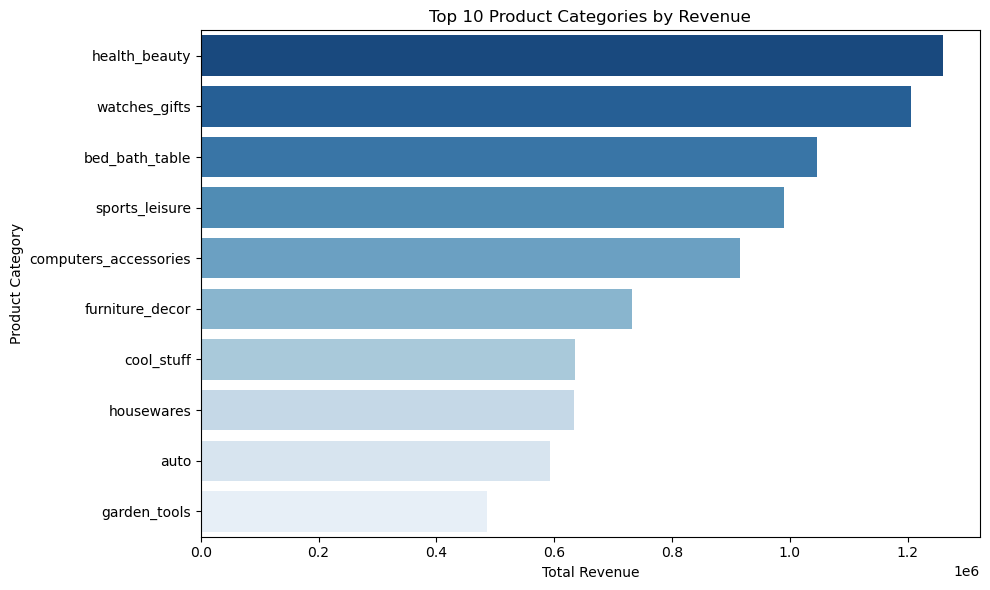

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 categories by revenue
top_revenue = df_product_perf.nlargest(10, 'total_revenue')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_revenue, x='total_revenue', y='product_category_name', palette='Blues_r')
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Total Revenue")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Which product categories are sold most often (volume)?

C:\Users\feder\AppData\Local\Temp\ipykernel_35072\3270398767.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_volume, x='total_sales_volume', y='product_category_name', palette='Greens_r')


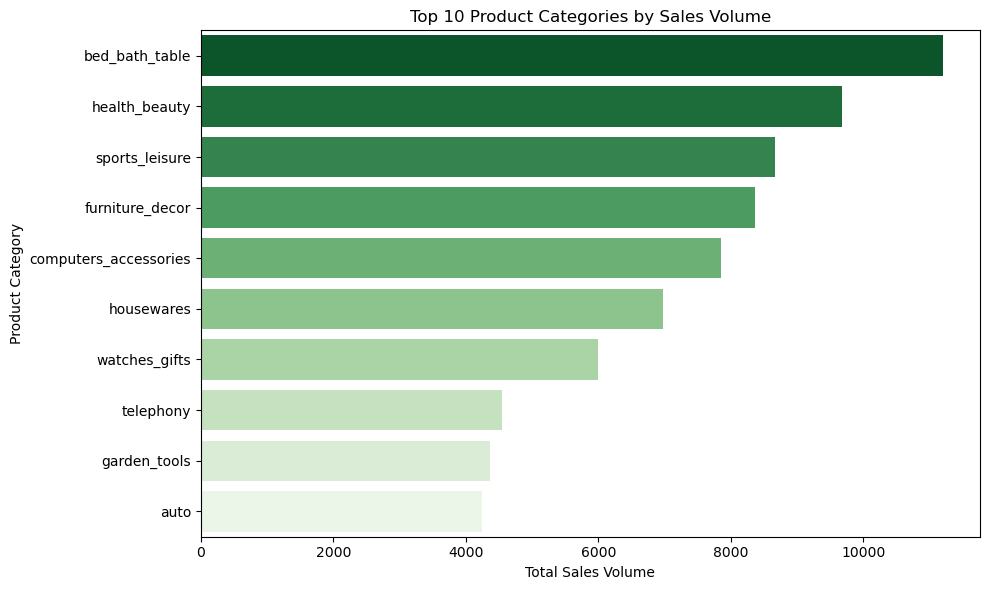

In [15]:
# Top 10 categories by sales volume
top_volume = df_product_perf.nlargest(10, 'total_sales_volume')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_volume, x='total_sales_volume', y='product_category_name', palette='Greens_r')
plt.title("Top 10 Product Categories by Sales Volume")
plt.xlabel("Total Sales Volume")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Which categories are rated best by customers (satisfaction)?

C:\Users\feder\AppData\Local\Temp\ipykernel_35072\1340161173.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_reviews, x='avg_review_score', y='product_category_name', palette='Purples_r')


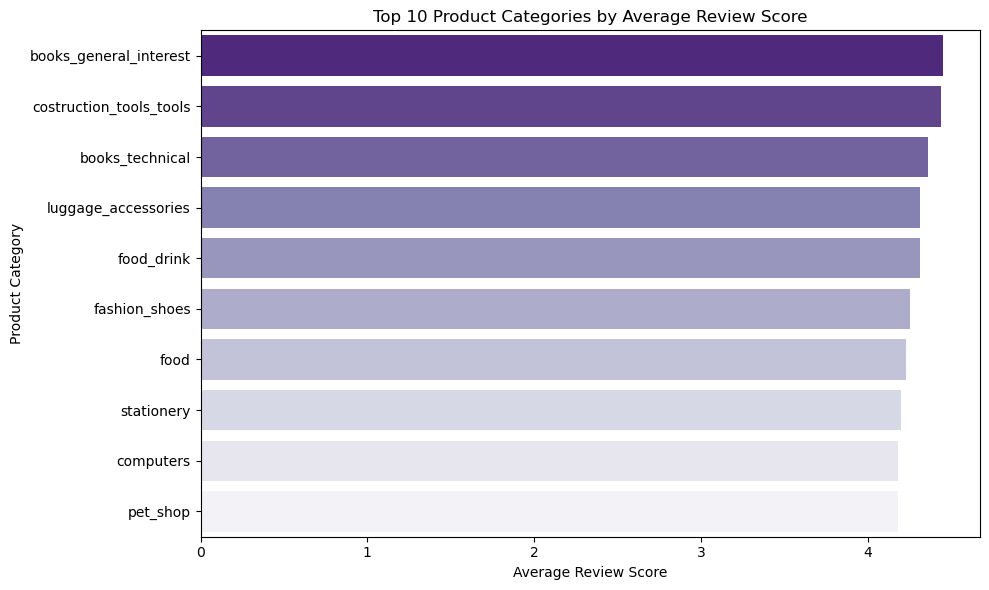

In [17]:
# Top 10 categories by average review score
top_reviews = df_product_perf[df_product_perf['total_sales_volume'] > 100]  # Filter to avoid low-volume noise
top_reviews = top_reviews.nlargest(10, 'avg_review_score')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_reviews, x='avg_review_score', y='product_category_name', palette='Purples_r')
plt.title("Top 10 Product Categories by Average Review Score")
plt.xlabel("Average Review Score")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Are some categories consistently delayed in delivery?

C:\Users\feder\AppData\Local\Temp\ipykernel_35072\2125815129.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_delay, x='avg_delivery_delay', y='product_category_name', palette='Reds_r')


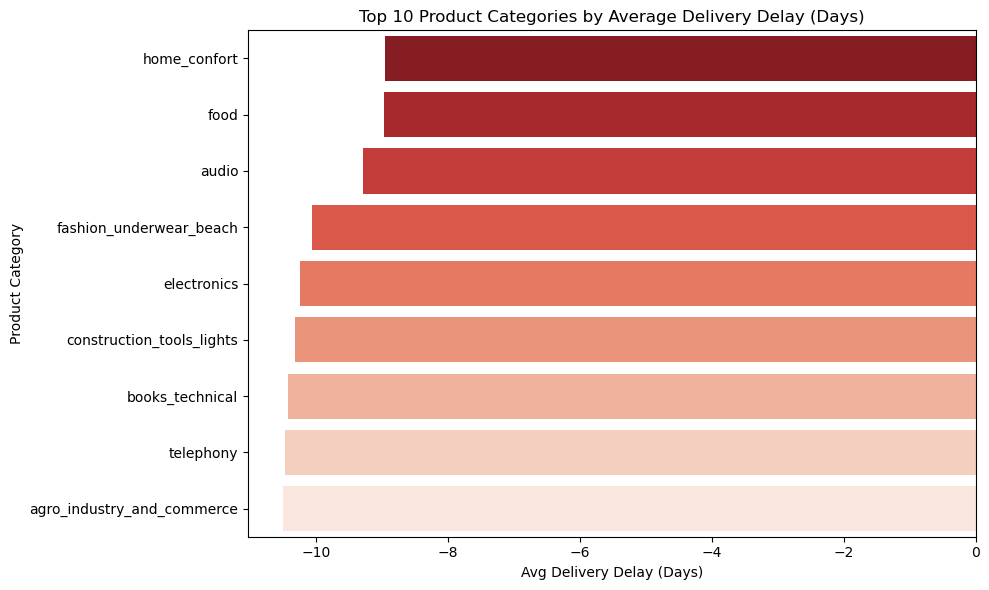

In [22]:
# Top 10 categories by average delivery delay
top_delay = df_product_perf[df_product_perf['total_sales_volume'] > 100]  # Filter low-volume
top_delay = top_delay.nlargest(10, 'avg_delivery_delay')

plt.figure(figsize=(10, 6))
sns.barplot(data=top_delay, x='avg_delivery_delay', y='product_category_name', palette='Reds_r')
plt.title("Top 10 Product Categories by Average Delivery Delay (Days)")
plt.xlabel("Avg Delivery Delay (Days)")
plt.ylabel("Product Category")
plt.tight_layout()
plt.show()


### Analysis of the Review Score

In [25]:
import psycopg2

# Reconnect to the database
conn = psycopg2.connect(
    host="localhost",
    database="Olist",
    user="postgres",
    password="hadoop",
    port="5432"
)

# Then run your query
query_reviews = """
SELECT review_score, COUNT(*) AS count
FROM olist_order_reviews
GROUP BY review_score
ORDER BY review_score;
"""

df_reviews = pd.read_sql_query(query_reviews, conn)

# Now close the connection again
conn.close()


C:\Users\feder\AppData\Local\Temp\ipykernel_35072\291903531.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_reviews = pd.read_sql_query(query_reviews, conn)


C:\Users\feder\AppData\Local\Temp\ipykernel_35072\2870141741.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_reviews, x="review_score", y="count", palette="rocket")


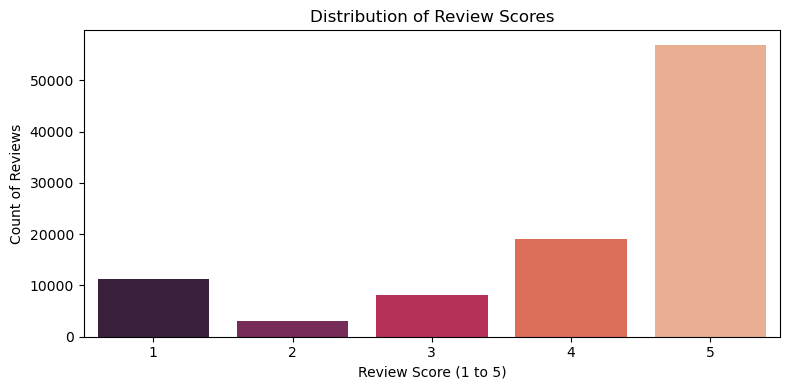

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(data=df_reviews, x="review_score", y="count", palette="rocket")
plt.title("Distribution of Review Scores")
plt.xlabel("Review Score (1 to 5)")
plt.ylabel("Count of Reviews")
plt.tight_layout()
plt.show()


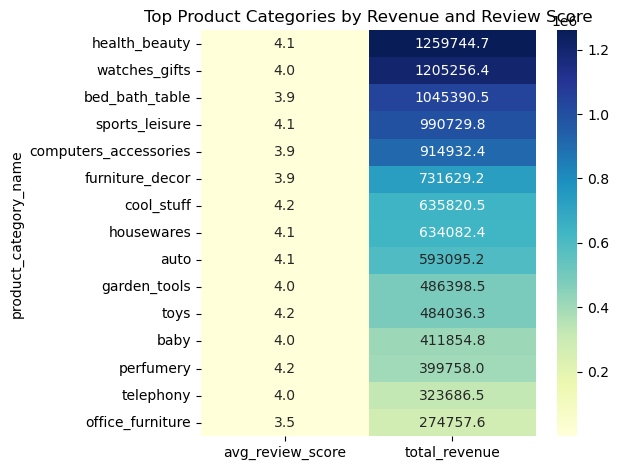

In [29]:
heatmap_data = df_product_perf.pivot_table(
    index='product_category_name',
    values=['total_revenue', 'avg_review_score'],
    aggfunc='mean'
).sort_values(by='total_revenue', ascending=False).head(15)

sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Top Product Categories by Revenue and Review Score")
plt.tight_layout()
plt.show()


## Segmentation of the products

## Objective
To segment product categories based on key performance metrics including total sales volume, total revenue, average customer review score, and average delivery delay‚Äîusing unsupervised machine learning techniques. The goal is to uncover distinct product performance profiles that can guide targeted marketing strategies, pricing decisions, and inventory management.

Outliers will be detected and excluded during the clustering process to ensure high-quality segmentation, and will optionally be reintegrated for post-clustering analysis.



In [35]:
# Basic inspection
print("Shape of dataset:", df_product_perf.shape)
print("\nColumn names:", df_product_perf.columns.tolist())

# Preview the data
df_product_perf.head()


Shape of dataset: (72, 5)

Column names: ['product_category_name', 'total_sales_volume', 'total_revenue', 'avg_review_score', 'avg_delivery_delay']


product_category_name  total_sales_volume  total_revenue  avg_review_score  \
0          health_beauty                9686     1259744.74              4.14   
1          watches_gifts                5997     1205256.44              4.02   
2         bed_bath_table               11202     1045390.52              3.90   
3         sports_leisure                8667      990729.77              4.11   
4  computers_accessories                7854      914932.36              3.94   

   avg_delivery_delay  
0              -11.06  
1              -11.01  
2              -10.74  
3              -11.10  
4              -11.50

In [37]:
#Check for missing values
df_product_perf.isnull().sum()


product_category_name    1
total_sales_volume       0
total_revenue            0
avg_review_score         0
avg_delivery_delay       0
dtype: int64

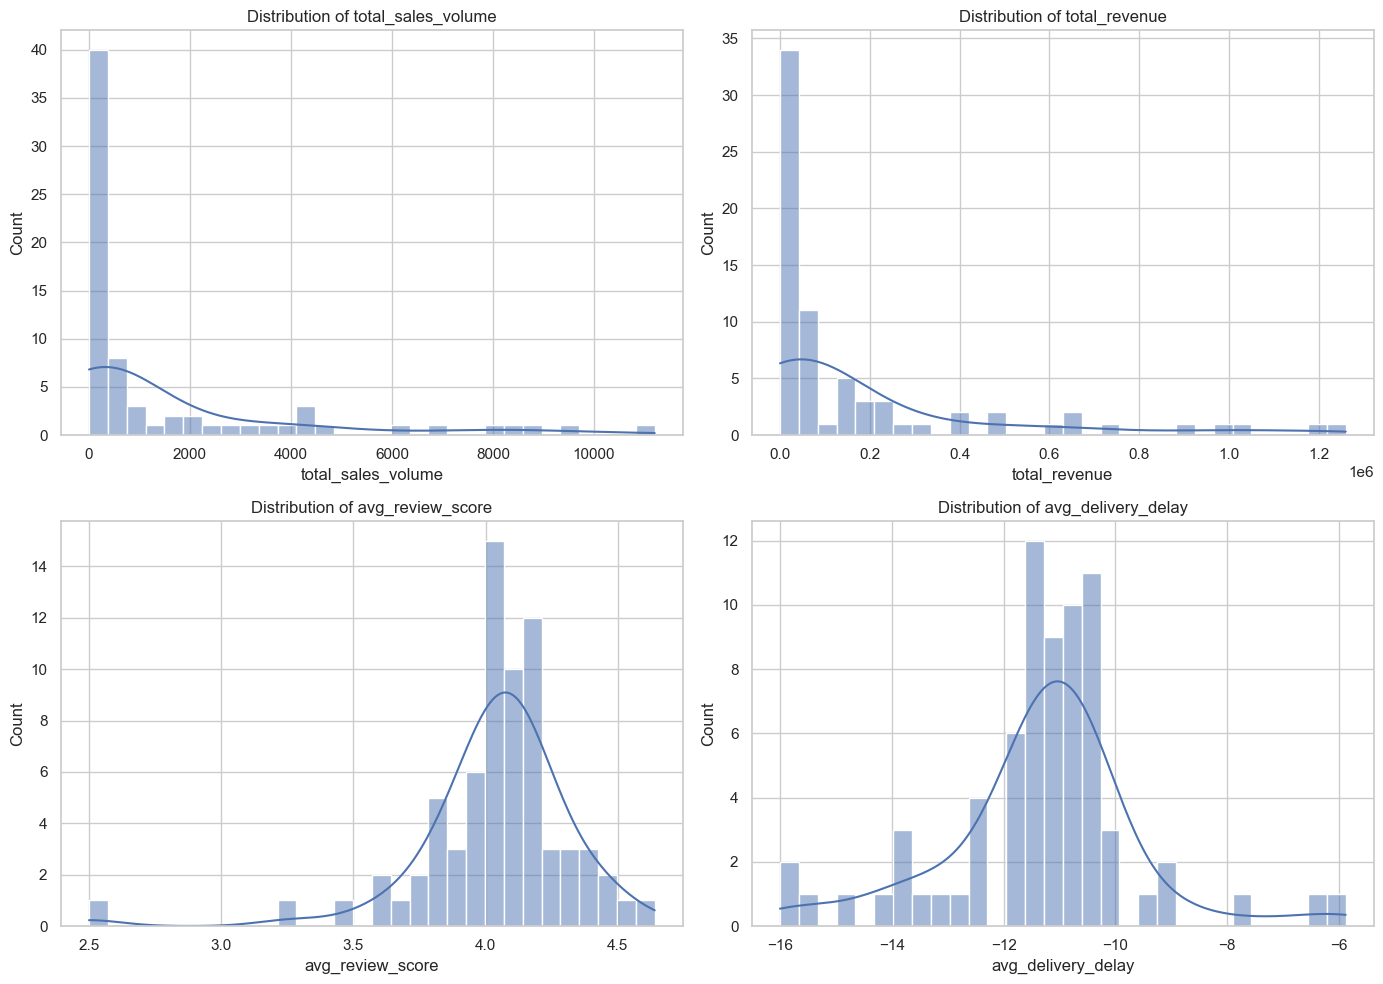

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
features = ['total_sales_volume', 'total_revenue', 'avg_review_score', 'avg_delivery_delay']

plt.figure(figsize=(14, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_product_perf[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()


In [40]:
import numpy as np

# Apply log1p to handle skew and zero values
df_product_perf['log_total_sales_volume'] = np.log1p(df_product_perf['total_sales_volume'])
df_product_perf['log_total_revenue'] = np.log1p(df_product_perf['total_revenue'])


In [41]:
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = ['log_total_sales_volume', 'log_total_revenue', 'avg_review_score', 'avg_delivery_delay']

# Fit scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_product_perf[features])


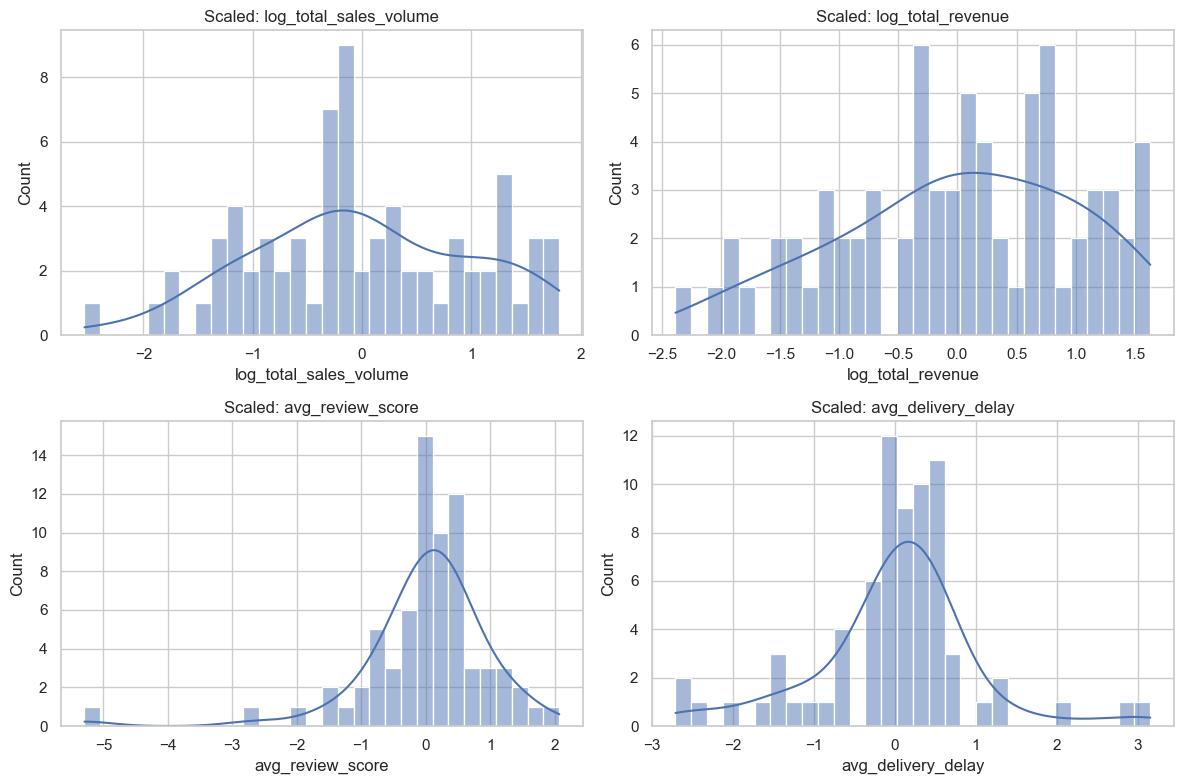

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert scaled array to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=features)

# Plot distributions
plt.figure(figsize=(12, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_scaled[col], kde=True, bins=30)
    plt.title(f'Scaled: {col}')
plt.tight_layout()
plt.show()


In [46]:
from scipy.stats import zscore
import numpy as np

# Compute z-scores from scaled data
z_scores = np.abs(zscore(df_scaled))

# Boolean mask: True where any feature has z > 3
outlier_mask = (z_scores > 3).any(axis=1)



In [49]:
# Separate outliers and clean data
df_outliers = df_product_perf[outlier_mask].copy()
df_clean = df_product_perf[~outlier_mask].copy()

# Add tags for later merging
df_outliers['outlier_flag'] = 'outlier'
df_clean['outlier_flag'] = 'clean'


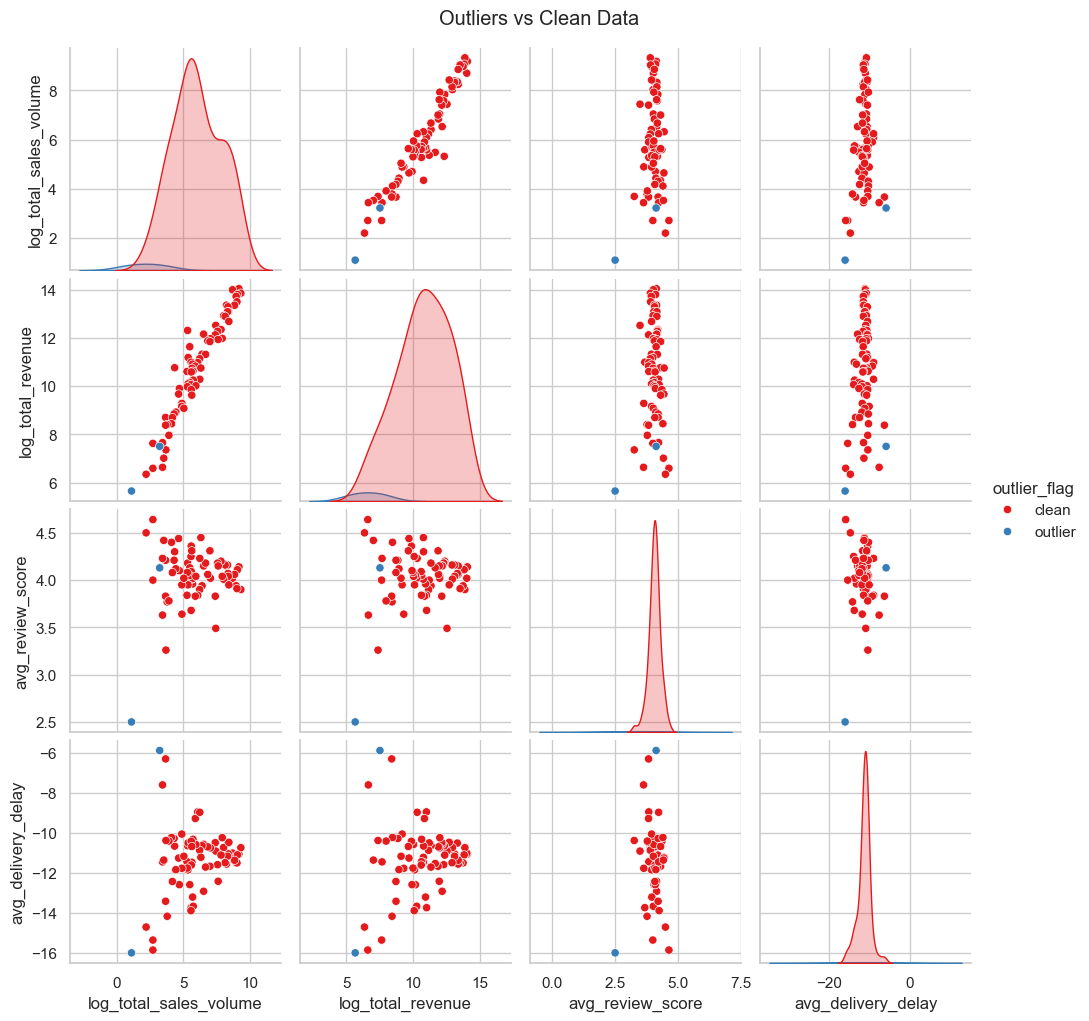

In [51]:
# Reconstruct combined DataFrame for visualization
df_combined = pd.concat([df_clean, df_outliers], axis=0)

# Plot comparison
sns.pairplot(df_combined, vars=features, hue='outlier_flag', palette='Set1')
plt.suptitle("Outliers vs Clean Data", y=1.02)
plt.show()


In [53]:
from sklearn.decomposition import PCA

# Select only the relevant features for PCA
X_clean = df_clean[features]

# Scale them again (best practice when reusing subsets)
X_scaled_clean = scaler.fit_transform(X_clean)

# Apply PCA
pca = PCA(n_components=2)
X_pca_clean = pca.fit_transform(X_scaled_clean)

# Add PCA components to df_clean for plotting
df_clean['PCA1'] = X_pca_clean[:, 0]
df_clean['PCA2'] = X_pca_clean[:, 1]


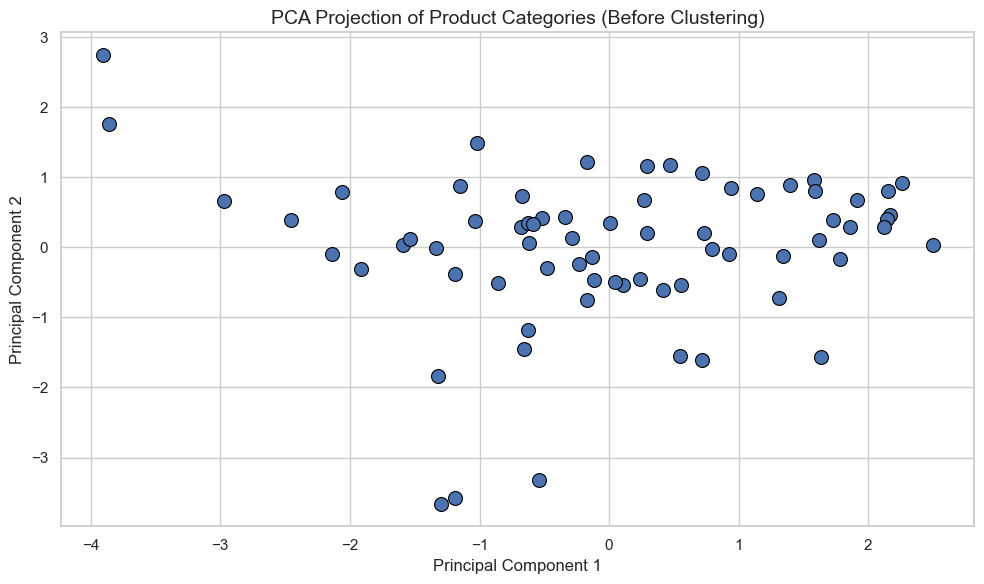

In [55]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    data=df_clean,
    s=100, edgecolor='black'
)
plt.title('PCA Projection of Product Categories (Before Clustering)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\feder\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\feder\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\feder\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\feder\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

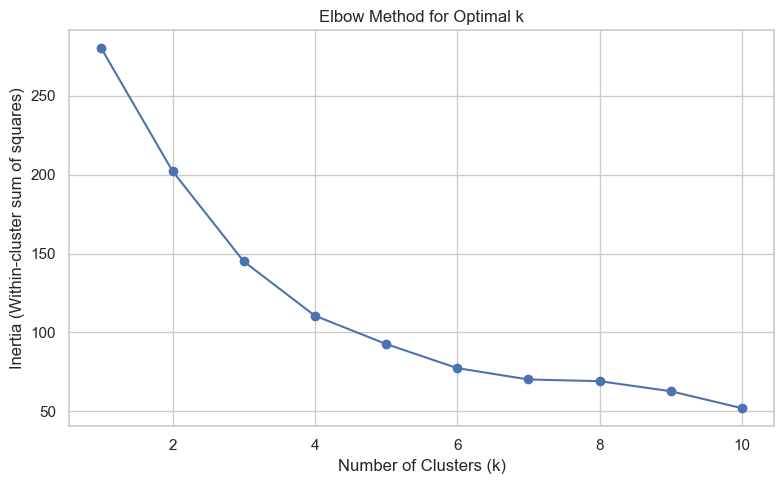

In [57]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Test k values from 1 to 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_clean)  # use scaled clean data
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
from sklearn.cluster import KMeans

# Fit KMeans on the cleaned and scaled data
kmeans = KMeans(n_clusters=4, random_state=42)
df_clean['cluster'] = kmeans.fit_predict(X_scaled_clean)


C:\Users\feder\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


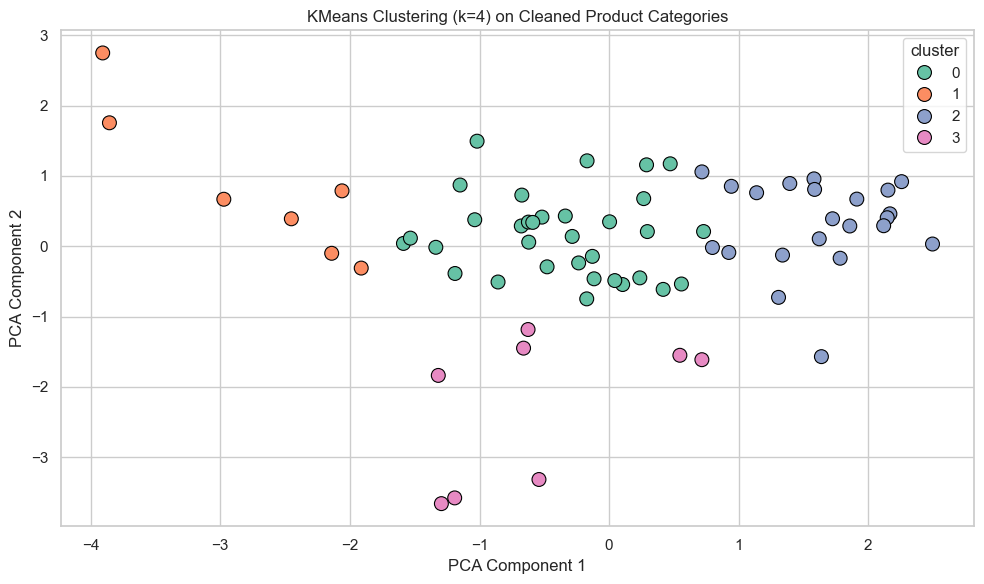

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='Set2',
    data=df_clean,
    s=100,
    edgecolor='black'
)
plt.title('KMeans Clustering (k=4) on Cleaned Product Categories')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
# Apply the same transformation pipeline to the outliers
X_outliers_scaled = scaler.transform(df_outliers[features])

# Predict clusters for outliers using the trained KMeans model
outlier_clusters = kmeans.predict(X_outliers_scaled)
df_outliers['cluster'] = outlier_clusters

# Combine clean data (already clustered) and outliers (just predicted)
df_final = pd.concat([df_clean, df_outliers], axis=0)

# Reset index for cleanliness
df_final = df_final.reset_index(drop=True)

# Confirm full recovery
print("Total product categories after reattaching outliers:", df_final.shape[0])
print("Clusters:", df_final['cluster'].value_counts().sort_index())


Total product categories after reattaching outliers: 72
Clusters: cluster
0    33
1     7
2    22
3    10
Name: count, dtype: int64


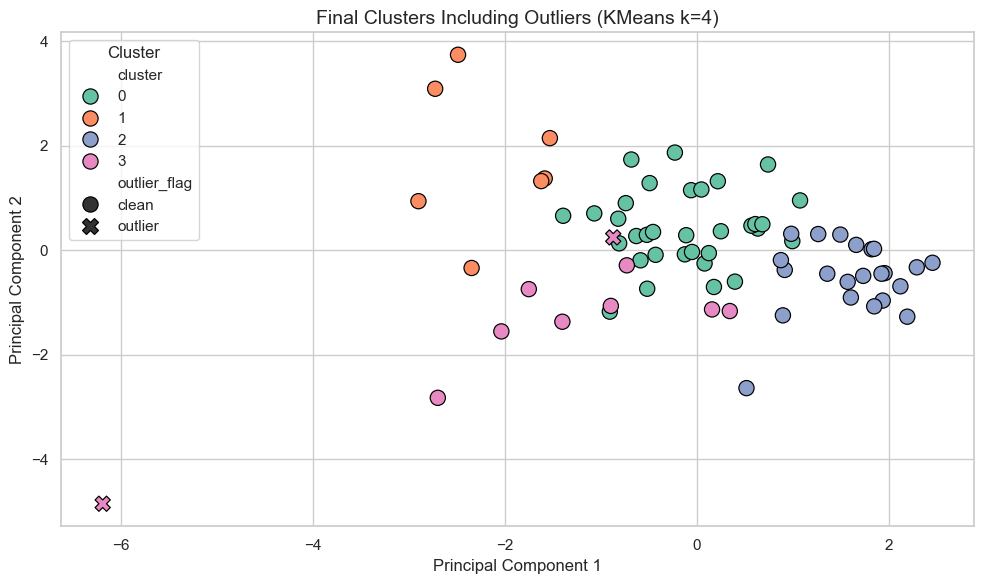

In [67]:
# Re-run PCA for all points
X_all_scaled = scaler.transform(df_final[features])
X_all_pca = pca.fit_transform(X_all_scaled)

df_final['PCA1'] = X_all_pca[:, 0]
df_final['PCA2'] = X_all_pca[:, 1]

# Plot with outliers and clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    data=df_final,
    palette='Set2',
    style='outlier_flag',
    s=120,
    edgecolor='black'
)
plt.title('Final Clusters Including Outliers (KMeans k=4)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [80]:
# Group by cluster and calculate feature means
cluster_summary = df_final.groupby('cluster')[
    ['log_total_sales_volume', 'log_total_revenue', 'avg_review_score', 'avg_delivery_delay']
].mean().round(2)

# Rename for clarity
cluster_summary.columns = [
    'Avg Log Sales Volume', 'Avg Log Revenue',
    'Avg Review Score', 'Avg Delivery Delay (days)'
]

In [82]:
# Copy to avoid modifying the original
cluster_summary_transformed = cluster_summary.copy()

# Apply inverse of log1p (which is expm1)
cluster_summary_transformed['Avg Sales Volume'] = np.expm1(cluster_summary_transformed['Avg Log Sales Volume']).round(2)
cluster_summary_transformed['Avg Revenue'] = np.expm1(cluster_summary_transformed['Avg Log Revenue']).round(2)

# Drop log columns
cluster_summary_transformed = cluster_summary_transformed.drop(columns=['Avg Log Sales Volume', 'Avg Log Revenue'])

# Reorder columns
cluster_summary_transformed = cluster_summary_transformed[
    ['Avg Sales Volume', 'Avg Revenue', 'Avg Review Score', 'Avg Delivery Delay (days)']
]

# Show updated cluster summary
cluster_summary_transformed




Avg Sales Volume  Avg Revenue  Avg Review Score  \
cluster                                                    
0                  246.15     34890.55              4.12   
1                   22.34      1771.24              4.25   
2                 3676.54    416648.24              4.03   
3                   58.15      4358.01              3.64   

         Avg Delivery Delay (days)  
cluster                             
0                           -11.48  
1                           -13.76  
2                           -11.07  
3                            -9.66

In [84]:
# Define cluster label mapping
cluster_labels = {
    2: "Top Sellers",
    0: "Reliable Performers",
    3: "Underperformers",
    1: "Niche Favorites"
}

# Create a new column with descriptive labels
df_clean['cluster_label'] = df_clean['cluster'].map(cluster_labels)

# Preview the result
df_clean[['cluster', 'cluster_label']].value_counts().sort_index()


cluster  cluster_label      
0        Reliable Performers    33
1        Niche Favorites         7
2        Top Sellers            22
3        Underperformers         8
Name: count, dtype: int64

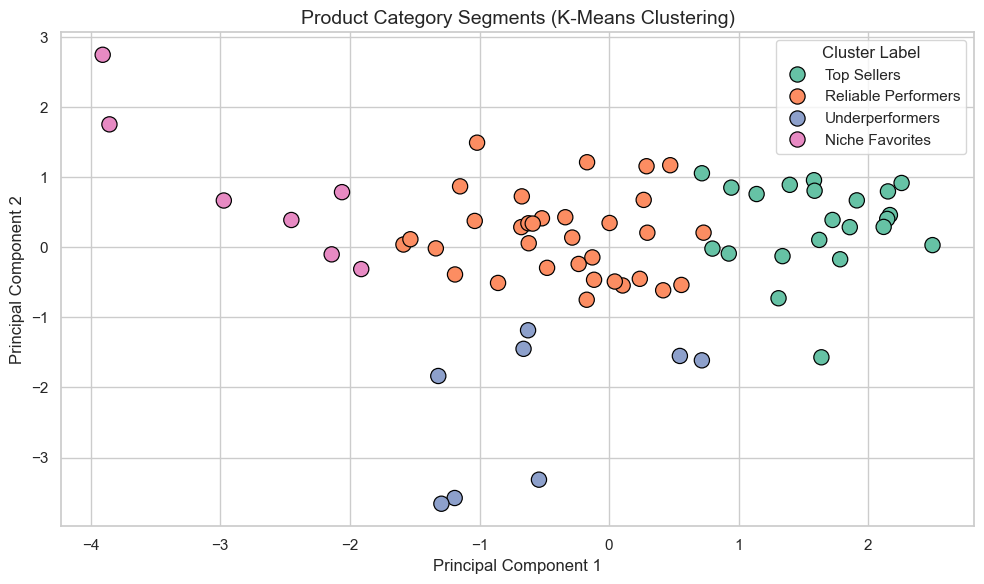

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='cluster_label',
    data=df_clean,
    palette='Set2',
    s=120,
    edgecolor='black'
)

plt.title('Product Category Segments (K-Means Clustering)', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:
# Assuming your product category name is stored in the index or in a column named 'product_category_name'
# If it's in the index:
df_clean_reset = df_clean.reset_index()

# Select relevant columns
clustered_products = df_clean_reset[['product_category_name', 'cluster_label']]

# Display the table
clustered_products.head(10)  # Show top 10 rows


product_category_name cluster_label
0          health_beauty   Top Sellers
1          watches_gifts   Top Sellers
2         bed_bath_table   Top Sellers
3         sports_leisure   Top Sellers
4  computers_accessories   Top Sellers
5        furniture_decor   Top Sellers
6             cool_stuff   Top Sellers
7             housewares   Top Sellers
8                   auto   Top Sellers
9           garden_tools   Top Sellers

### üß© Clustering Analysis Summary

The clustering analysis segmented product categories into **four strategic groups** based on:

- Sales volume  
- Revenue  
- Customer reviews  
- Delivery performance  

#### 1. **Top Sellers** (e.g., *Cluster 2*)
- üî• **High-performing** categories with very strong **sales** and **revenue**
- ‚úÖ Ideal for **continued investment**, **marketing campaigns**, and **inventory prioritization**

#### 2. **Reliable Performers** (*Cluster 0*)
- üì¶ **Moderate sales and revenue**
- üåü Consistently high **customer satisfaction** and **timely delivery**
- üí° Suitable for **brand loyalty programs**, **bundles**, or **subscription models**

#### 3. **Low Impact Products** (*Cluster 1*)
- üìâ **Low sales and revenue**
- üëç Surprisingly **positive reviews** and **good delivery performance**
- üéØ May represent **niche items** worth **precision marketing** or **seasonal promotion**

#### 4. **Growing Categories** (*Cluster 3*)
- üìä **Moderate performance**, but with **lower customer satisfaction**
- ‚öôÔ∏è Potential for improvement through:
  - Service optimization
  - Pricing strategy adjustments
  - Review/feedback management

---

Each segment offers **distinct opportunities** for:

- üéØ **Strategic marketing**
- üõ†Ô∏è **Operational focus**
- üë• **Targeted customer engagement**


In [80]:
print(df_clean.columns.tolist())


['product_category_name', 'total_sales_volume', 'total_revenue', 'avg_review_score', 'avg_delivery_delay', 'log_total_revenue', 'log_total_sales_volume', 'outlier_flag', 'PCA1', 'PCA2', 'cluster', 'cluster_label']


In [82]:
# Select relevant columns for export
df_cluster_export = df_clean[['product_category_name', 'total_sales_volume', 'total_revenue',
                              'avg_review_score', 'avg_delivery_delay', 'cluster', 'cluster_label']]

# Export to CSV
df_cluster_export.to_csv('product_segmentation.csv', index=False)
